In [1]:
#import random
import torch as tc
import numpy as np
import qutip as qt
import pandas as pd
import function as my
import matplotlib.pyplot as plt

from tqdm import tqdm


class SIN(tc.nn.Module):
    def __init__(self): 
        super(SIN, self).__init__() 
    def forward(self, x):
        return tc.sin(x)

In [2]:
# Carregar os arquivos CSV
sx_data = pd.read_csv('sx_new.csv')
sy_data = pd.read_csv('sy.csv')
sz_data = pd.read_csv('sz.csv')

sx_data_sorted = sx_data.sort_values(by=sx_data.columns[0])
sy_data_sorted = sy_data.sort_values(by=sy_data.columns[0])
sz_data_sorted = sz_data.sort_values(by=sz_data.columns[0])

sx_data = tc.tensor(sx_data_sorted.iloc[:, 1].values).view(-1,1)
sy_data = tc.tensor(sy_data_sorted.iloc[:, 1].values).view(-1,1)  
sz_data = tc.tensor(sz_data_sorted.iloc[:, 1].values).view(-1,1)

#valor_esperado_data = tc.cat((sx_data, sy_data, sz_data), dim=1)
time_dataX = tc.tensor(sx_data_sorted.iloc[:, 0].values,dtype=tc.float).view(-1,1)
time_dataY = tc.tensor(sy_data_sorted.iloc[:, 0].values,dtype=tc.float).view(-1,1)
time_dataZ = tc.tensor(sz_data_sorted.iloc[:, 0].values,dtype=tc.float).view(-1,1)

In [3]:

# # Plotando as curvas de sy_data
# plt.plot(sx_data_sorted.iloc[:, 0],sx_data_sorted.iloc[:, 1],"k.", label='sx_data')
# plt.plot(sy_data_sorted.iloc[:, 0],sy_data_sorted.iloc[:, 1],"b.", label='sy_data')
# plt.plot(sz_data_sorted.iloc[:, 0],sz_data_sorted.iloc[:, 1],"r.", label='sy_data')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()
# plt.show()


In [4]:
def data_qubit(lista_J,dissipation,tfinal,N,O_op,device="cpu"):
    # Operadores de Pauli para cada qubit
    X,Y,Z =qt.sigmax(),qt.sigmay(),qt.sigmaz()

    operadores = [X,Y,Z]
    
    H = 0
    for i in range(len(lista_J)):
        H += lista_J[i]*operadores[i]

    # Hamiltonian Lindbladian
    c_ops = [np.sqrt(dissipation[0])*qt.sigmam(),
             np.sqrt(dissipation[1])*qt.sigmaz(),
             np.sqrt(dissipation[2])*qt.sigmam().dag()]
    
    # Estado inicial (cada qubit na superposição de |0> e |1>)
    # theta1  = np.pi/4
    # phi1    = 0.0 
    # # ket_plus1 = (np.cos(theta1)*qt.basis(2, 0)+np.sin(theta1)*np.exp(1j*phi1)*qt.basis(2, 1))

    # # |+> = (|0> + |1>)/sqrt(2)
    # ket_plus1 = (qt.basis(2, 0)+  qt.basis(2, 1))/2
    rho0 = (1 + 0.380469*qt.sigmax() +-0.9766*qt.sigmaz() )/2
    rho0 = (1 + 0*qt.sigmax() -1*qt.sigmaz() )/2
    #psi0    = ket_plus1
    
    # Lista de tempos para a evolução
    tlist   = np.linspace(0.0, tfinal, N)

    # Solução da equação de Schrödinger
    options = qt.Options(nsteps = 100000, atol = 1e-14, rtol = 1e-14)
    result  = qt.mesolve(H, rho0, tlist, c_ops=c_ops, e_ops=O_op,options=options)

    expect  = tc.tensor( np.array( result.expect),device = device).transpose(0, 1)
    return expect

O_op =[ qt.sigmax(),
        qt.sigmay(),
        qt.sigmaz()]


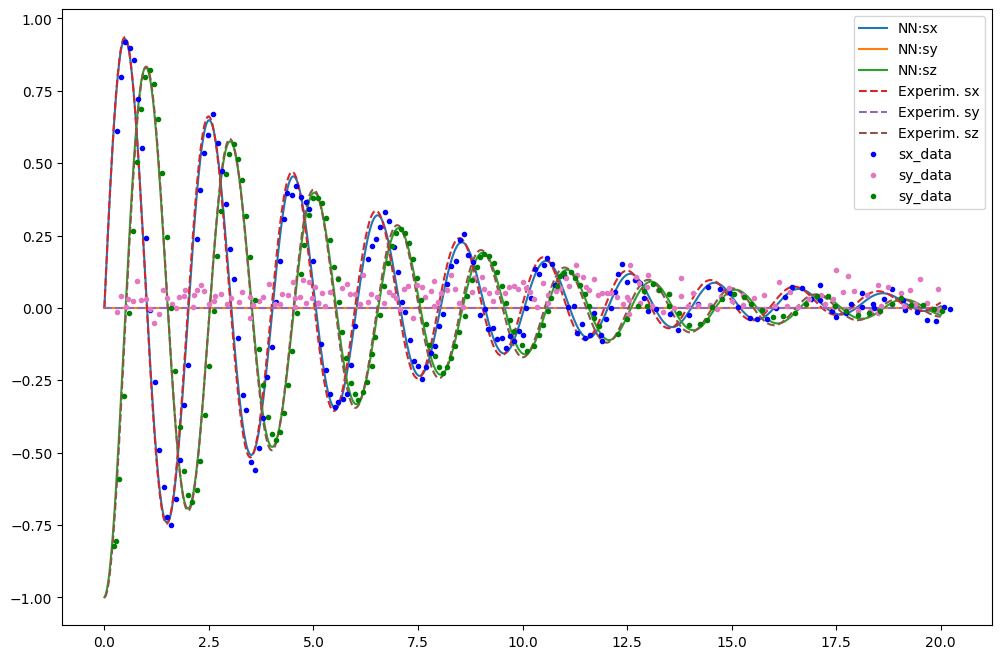

[ 0.         -1.57079633  0.        ] [0.065  0.1279 0.0013]


In [13]:
plt.figure(figsize=(12, 8))  # Define o tamanho da figura (largura, altura)
tfinal      = 20
N           = 1000
tlist   = np.linspace(0, tfinal, N)
S = ['sx','sy','sz']


Js          = np.array([ 0.0, -1.5598,0.0])# np.random.uniform(-1,1,3)
dissipation = np.array([ 0.1281,  0.0305,  0.0745])# np.random.uniform(0,1,3)

valor_esperado_data  = data_qubit(Js,dissipation,tfinal,N,O_op,device="cpu")

for i in range(len(O_op)):
    plt.plot(tlist,valor_esperado_data[:,i].cpu() ,label=f"NN:"+ S[i])

Js          = np.array([0,-np.pi/2,0.000])# np.random.uniform(-1,1,3)
dissipation = np.array([0.065,0.1279,0.0013])# np.random.uniform(0,1,3)
valor_esperado_data  = data_qubit(Js,dissipation,tfinal,N,O_op,device="cpu")

for i in range(len(O_op)):
    plt.plot(tlist,valor_esperado_data[:,i].cpu() ,'--',label=f"Experim. " + S[i])

# Plotando as curvas de sy_data
plt.plot(sx_data_sorted.iloc[:, 0],sx_data_sorted.iloc[:, 1],"b.", label='sx_data')
plt.plot(sy_data_sorted.iloc[:, 0],sy_data_sorted.iloc[:, 1],".", label='sy_data')
plt.plot(sz_data_sorted.iloc[:, 0],sz_data_sorted.iloc[:, 1],"g.", label='sy_data')
plt.legend()

plt.show()
print(Js,dissipation)

In [6]:
tfinal      = 20
N           = 1000

O_op =[ qt.sigmax(),
        qt.sigmay(),
        qt.sigmaz()]

In [7]:
neuronio = [50,50]
X_vector   = my.Rede(
    neuronio    = neuronio,
    input_      = 1,
    output_     = len(O_op),
    activation  =[tc.nn.Tanh()]*len(neuronio),
    creat_p     =True,
    N_of_paramater= 4,
    dropout_prob=  0.0)
opt = tc.optim.Adam(X_vector.parameters(),
        lr = 0.001 )
time =  tc.linspace(
        0,
        tfinal,
        N,
        dtype   = tc.float32,
        requires_grad = True).reshape((-1, 1))
#index_data = np.random.randint(0,N,size=100)
X_vector.parametro

Parameter containing:
tensor([0.0833, 0.9144, 0.0449, 0.8355], requires_grad=True)

100%|██████████| 50000/50000 [16:45<00:00, 49.71it/s]


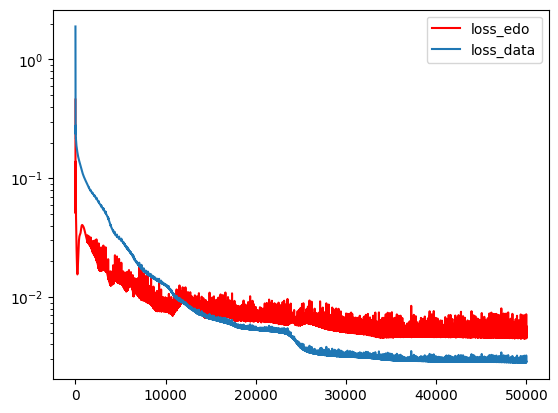

Valor final: Parameter containing:
tensor([-1.5230,  0.0708,  0.1236,  0.0086], requires_grad=True)


In [8]:
epocas  = 50000
LOSS    = []
LOSS1   = []
LOSS2   = []
hisorty_of_param = []
for _ in tqdm(range(epocas)):
    ####### Forward pass #######
    y  = X_vector(time)     
    
    ######## Los edo #######
    dX_dt = []
    for i in range(y.shape[1]):
        dX_dt.append(tc.autograd.grad(outputs = y[:, i], 
                                    inputs = time,
                                    grad_outputs = tc.ones_like(y[:, i]),
                                    #retain_graph = True,
                                    create_graph = True)[0])
    dX_dt   = tc.cat(dX_dt, dim=1)
    
    X,Y,Z = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    #JX,JY,JZ,gamma1,gamma2,gamma3 = X_vector.parametro
    JY,gamma1,gamma2,gamma3 = X_vector.parametro
    JX,JZ = 0,0
    LOSS_edo  = 0
    LOSS_edo += (dX_dt[:,0:1] - ( + (-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3)*X + (-2.0*JZ)*Y + (2.0*JY)*Z))**2
    LOSS_edo += (dX_dt[:,1:2] - ( + (2.0*JZ)*X + (-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3)*Y + (-2.0*JX)*Z))**2
    LOSS_edo += (dX_dt[:,2:3] - ( + (-1.0*gamma1 + 1.0*gamma3) + (-2.0*JY)*X + (2.0*JX)*Y + (-1.0*gamma1 - 1.0*gamma3)*Z))**2
    LOSS_edo = LOSS_edo.mean() 
    
    ####### loss data(expected values) #######
    ####### Forward pass #######
    y  = X_vector(time_dataX) 
    LOSS_data = tc.mean((y[:,:1]  - sx_data)**2) 
    
    y  = X_vector(time_dataY) 
    LOSS_data += tc.mean((y[:,1:2]  - sy_data)**2) 
    
    y  = X_vector(time_dataZ) 
    LOSS_data += tc.mean((y[:,2:3]  - sz_data)**2) 
    
    
    ####### Forward pass #######
    y  = X_vector(time[:1]) 
    LOSS_data += tc.mean((y[0,:1]  - 0)**2) 
    LOSS_data += tc.mean((y[0,1:2]  - 0)**2) 
    LOSS_data += tc.mean((y[0,2:3]  - (-1))**2) 
    #print(y)
    
    ####### Loss total #######
    loss_i = LOSS_edo*0.1 + LOSS_data
    
    ####### Backpropagation #######
    opt.zero_grad()
    loss_i.backward()
    opt.step()
    LOSS1.append(LOSS_edo.cpu().detach().numpy())
    LOSS2.append(LOSS_data.cpu().detach().numpy())
    LOSS.append(loss_i.cpu().detach().numpy())
    
#plt.plot(LOSS,"k.",label="loss_total")
plt.plot(LOSS1,'r-',label="loss_edo")
plt.plot(LOSS2,label="loss_data")
plt.yscale("log")
plt.legend()
plt.show()
print("Valor final:",X_vector.parametro)

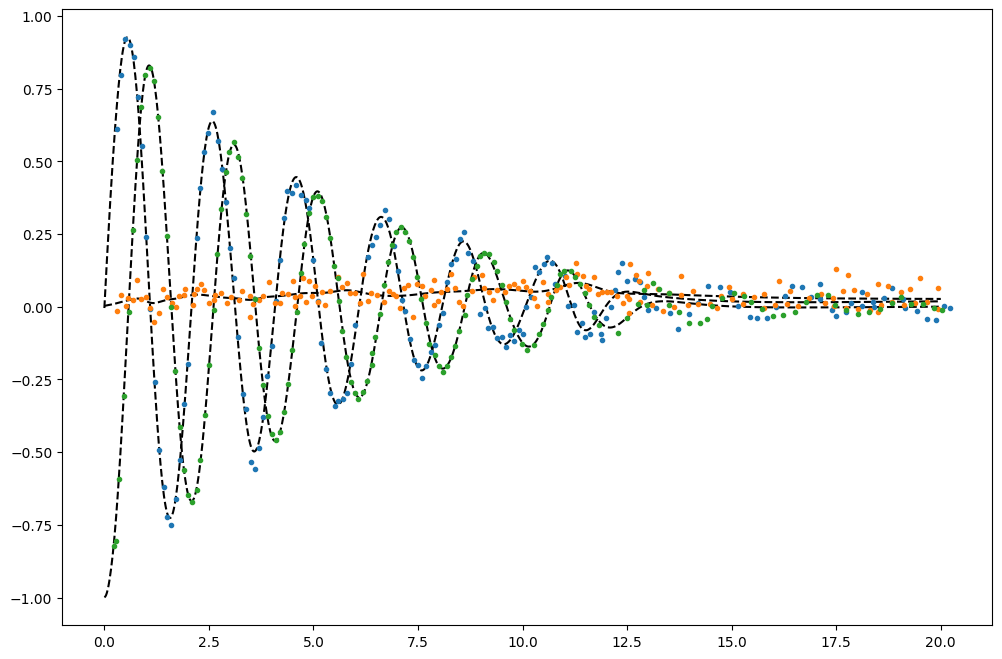

In [9]:
plt.figure(figsize=(12, 8))
X_vector.eval()
X_  = X_vector(time).detach().numpy()

for i in range(len(O_op)):
    plt.plot(time.detach().numpy(), X_[:,i],"k--")
    #plt.plot(valor_esperado_data[:,i].cpu(),"k." ,label=f"O_{i}")

####### Forward pass #######
y  = X_vector(time_dataX) 
plt.plot(time_dataX,sx_data.cpu(),"." ,label=f"O_{i}")

y  = X_vector(time_dataY) 
plt.plot(time_dataY,sy_data.cpu(),"." ,label=f"O_{i}")

y  = X_vector(time_dataZ) 
plt.plot(time_dataZ,sz_data.cpu(),"." ,label=f"O_{i}")

plt.show()
#abs(X_vector.parametro -tc.tensor(np.concatenate((Js, dissipation))))

In [10]:
X_vector.parametro

Parameter containing:
tensor([-1.5230,  0.0708,  0.1236,  0.0086], requires_grad=True)

In [11]:
print("Omega: ",np.pi/2, " obtido: ",X_vector.parametro[1].item())
print("T1 : ", 1/15 )
print("Td : ", 1/5 )
print("Tphi : ", 1/17.9 )

Omega:  1.5707963267948966  obtido:  0.07075560837984085
T1 :  0.06666666666666667
Td :  0.2
Tphi :  0.0558659217877095


In [12]:
(1/5 + 1/17.9 )/2

0.12793296089385475